In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
import cv2,os
import numpy as np
from keras.utils import np_utils
import tensorflow as tf
import keras
import imutils
import pytesseract

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data_path='../data/project/'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels))

In [4]:
label_dict

{'angry': 0, 'smile': 1}

In [5]:
data=[]
target=[]

for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
            resized=cv2.resize(gray,(100, 100))
            data.append(resized)
            target.append(label_dict[category])

        except Exception as e:
            print('Exception:', e)

In [6]:
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0], 100, 100, 1))
target=np.array(target)

new_target=np_utils.to_categorical(target)

np.save('data', data)
np.save('target', new_target)

In [7]:
data=np.load('data.npy')
target=np.load('target.npy')

In [8]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from tensorflow.python.keras.optimizer_v2 import rmsprop
from sklearn.model_selection import train_test_split

In [9]:
train_data,test_data,train_target,test_target=train_test_split(data,target, test_size=0.2, random_state=42)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(rotation_range=20, 
                         zoom_range=0.2, 
                         width_shift_range=0.2, 
                         height_shift_range=0.2, 
                         shear_range=0.15, 
                         horizontal_flip=True,
                         fill_mode="nearest")

In [11]:
input_shape=data.shape[1:]
input_shape

(100, 100, 1)

In [12]:
def get_model(input_shape, dropout2_rate=0.5):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, name="conv2d_1"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), name="maxpool2d_1"))
    model.add(Dropout(0.25, name="dropout_1"))

    model.add(Conv2D(64, (3, 3), activation='relu', name="conv2d_2"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), name="maxpool2d_2"))
    model.add(Dropout(0.25, name="dropout_2"))

    model.add(Conv2D(128, (3, 3), activation='relu', name="conv2d_3"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), name="maxpool2d_3"))
    model.add(Dropout(0.25, name="dropout_3"))

    model.add(Flatten(name="flatten"))
    model.add(Dense(512, activation='relu', name="dense_1"))
    model.add(BatchNormalization())
    model.add(Dropout(dropout2_rate, name="dropout_4"))
    model.add(Dense(2, activation='softmax', name="dense_2"))
    return model

In [13]:
def fit_with(input_shape, verbose, dropout2_rate, lr):

    model = get_model(input_shape, dropout2_rate)
    
    optimizer = rmsprop.RMSProp(learning_rate=lr)
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    model.fit(train_data, train_target, epochs=10,
              batch_size=4, verbose=verbose)

    score = model.evaluate(test_data, test_target, steps=10, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return score[1]

In [14]:
from functools import partial

verbose = 1
fit_with_partial = partial(fit_with, input_shape, verbose)

In [15]:
from bayes_opt import BayesianOptimization

pbounds = {'dropout2_rate': (0.1, 0.5), 'lr': (1e-4, 1e-2)}

optimizer = BayesianOptimization(
    f=fit_with_partial,
    pbounds=pbounds,
    verbose=2, 
    random_state=1,
)

optimizer.maximize(init_points=10, n_iter=10)

for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

|   iter    |  target   | dropou... |    lr     |
-------------------------------------------------
Epoch 1/10
249/249 [==============================] - 8s 10ms/step - loss: 1.5190 - accuracy: 0.6533
Epoch 2/10
249/249 [==============================] - 2s 9ms/step - loss: 0.9246 - accuracy: 0.7567
Epoch 3/10
249/249 [==============================] - 2s 9ms/step - loss: 0.8660 - accuracy: 0.7783
Epoch 4/10
249/249 [==============================] - 2s 9ms/step - loss: 0.6734 - accuracy: 0.7917
Epoch 5/10
249/249 [==============================] - 2s 10ms/step - loss: 0.5502 - accuracy: 0.8125
Epoch 6/10
249/249 [==============================] - 2s 10ms/step - loss: 0.4820 - accuracy: 0.8391
Epoch 7/10
249/249 [==============================] - 2s 9ms/step - loss: 0.3528 - accuracy: 0.8877
Epoch 8/10
249/249 [==============================] - 2s 10ms/step - loss: 0.3890 - accuracy: 0.8654
Epoch 9/10
249/249 [==============================] - 2s 9ms/step - loss: 0.3319 - accuracy: 0.8

249/249 [==============================] - 4s 11ms/step - loss: 1.3494 - accuracy: 0.7087
Epoch 2/10
249/249 [==============================] - 3s 11ms/step - loss: 0.7805 - accuracy: 0.7561
Epoch 3/10
249/249 [==============================] - 3s 11ms/step - loss: 0.6403 - accuracy: 0.8075
Epoch 4/10
249/249 [==============================] - 3s 11ms/step - loss: 0.5823 - accuracy: 0.8105
Epoch 5/10
249/249 [==============================] - 3s 11ms/step - loss: 0.4663 - accuracy: 0.8354
Epoch 6/10
249/249 [==============================] - 3s 11ms/step - loss: 0.4117 - accuracy: 0.8480
Epoch 7/10
249/249 [==============================] - 3s 11ms/step - loss: 0.3676 - accuracy: 0.8751
Epoch 8/10
249/249 [==============================] - 3s 11ms/step - loss: 0.3452 - accuracy: 0.8799
Epoch 9/10
249/249 [==============================] - 3s 11ms/step - loss: 0.2544 - accuracy: 0.9052
Epoch 10/10
249/249 [==============================] - 3s 11ms/step - loss: 0.2956 - accuracy: 0.8794


249/249 [==============================] - 3s 13ms/step - loss: 0.2926 - accuracy: 0.9003 2s - loss: 0.4197  - ETA: 2s - loss: 0.336 - ETA: 1s - loss: 0.3165 -  - ETA: 1s - loss: 0.3 - ETA: 0s - loss: 0.2961 - accura - ETA: 0s - loss: 0.2939 - ac
Epoch 7/10
249/249 [==============================] - 3s 13ms/step - loss: 0.3228 - accuracy: 0.8804
Epoch 8/10
249/249 [==============================] - 3s 13ms/step - loss: 0.3459 - accuracy: 0.8669
Epoch 9/10
249/249 [==============================] - 3s 13ms/step - loss: 0.2785 - accuracy: 0.8912
Epoch 10/10
249/249 [==============================] - 3s 13ms/step - loss: 0.2730 - accuracy: 0.9093
Test loss: 1.6254922151565552
Test accuracy: 0.7269076108932495
|  14       |  0.7269   |  0.1578   |  0.001716 |
Epoch 1/10
249/249 [==============================] - 5s 13ms/step - loss: 1.0550 - accuracy: 0.7061 1s - loss: 1.2469  - ETA: 1s - l - ETA: 0s - loss: 1.0868 - 
Epoch 2/10
249/249 [==============================] - 3s 13ms/step - los

249/249 [==============================] - 5s 18ms/step - loss: 0.3457 - accuracy: 0.8661
Epoch 6/10
249/249 [==============================] - 4s 18ms/step - loss: 0.3226 - accuracy: 0.8937
Epoch 7/10
249/249 [==============================] - 5s 18ms/step - loss: 0.3332 - accuracy: 0.8858
Epoch 8/10
249/249 [==============================] - 5s 18ms/step - loss: 0.2205 - accuracy: 0.9131
Epoch 9/10
249/249 [==============================] - 4s 18ms/step - loss: 0.2747 - accuracy: 0.9157
Epoch 10/10
249/249 [==============================] - 5s 19ms/step - loss: 0.1785 - accuracy: 0.9281
Test loss: 0.32684388756752014
Test accuracy: 0.8955823183059692
|  20       |  0.8956   |  0.1592   |  0.000992 |
Iteration 0: 
	{'target': 0.7710843086242676, 'params': {'dropout2_rate': 0.2668088018810296, 'lr': 0.007231212485077366}}
Iteration 1: 
	{'target': 0.8835341334342957, 'params': {'dropout2_rate': 0.10004574992693796, 'lr': 0.003093092469055214}}
Iteration 2: 
	{'target': 0.93172693252563

In [16]:
print(optimizer.max)

{'target': 0.9317269325256348, 'params': {'dropout2_rate': 0.15870235632684523, 'lr': 0.0010141520882110983}}


In [17]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=data.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1587))
model.add(Dense(2, activation='softmax'))

In [18]:
opt = keras.optimizers.Adam(learning_rate=0.00101)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50)
checkpoint = ModelCheckpoint(
    '../data/capture1/{epoch:03d}-{val_loss:.4f}.model',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    mode='auto')

In [20]:
history=model.fit(aug.flow(train_data, train_target), 
                  epochs=100, 
                  batch_size=4,
                  callbacks=[checkpoint, early_stopping],
                  validation_data=(test_data, test_target))

print(model.evaluate(test_data,test_target))

Epoch 1/100
32/32 [==============================] - 3s 73ms/step - loss: 1.4925 - accuracy: 0.5804 - val_loss: 0.7116 - val_accuracy: 0.4779
INFO:tensorflow:Assets written to: ../data/capture1\001-0.7116.model\assets
Epoch 2/100
32/32 [==============================] - 2s 60ms/step - loss: 0.5812 - accuracy: 0.7359 - val_loss: 2.7437 - val_accuracy: 0.2008
Epoch 3/100
32/32 [==============================] - 2s 54ms/step - loss: 0.5044 - accuracy: 0.7854 - val_loss: 3.3404 - val_accuracy: 0.1968
Epoch 4/100
32/32 [==============================] - 2s 55ms/step - loss: 0.4913 - accuracy: 0.8000 - val_loss: 3.3102 - val_accuracy: 0.2008
Epoch 5/100
32/32 [==============================] - 2s 56ms/step - loss: 0.4937 - accuracy: 0.7906 - val_loss: 5.5299 - val_accuracy: 0.2008
Epoch 6/100
32/32 [==============================] - 2s 56ms/step - loss: 0.4285 - accuracy: 0.8316 - val_loss: 9.1535 - val_accuracy: 0.2008
Epoch 7/100
32/32 [==============================] - 2s 56ms/step - loss

32/32 [==============================] - 2s 63ms/step - loss: 0.2700 - accuracy: 0.9000 - val_loss: 0.2875 - val_accuracy: 0.8715
INFO:tensorflow:Assets written to: ../data/capture1\053-0.2875.model\assets
Epoch 54/100
32/32 [==============================] - 2s 59ms/step - loss: 0.2489 - accuracy: 0.8945 - val_loss: 0.5408 - val_accuracy: 0.7309
Epoch 55/100
32/32 [==============================] - 2s 60ms/step - loss: 0.2523 - accuracy: 0.8917 - val_loss: 0.2982 - val_accuracy: 0.8635
Epoch 56/100
32/32 [==============================] - 2s 58ms/step - loss: 0.2584 - accuracy: 0.8868 - val_loss: 1.1010 - val_accuracy: 0.6908
Epoch 57/100
32/32 [==============================] - 2s 62ms/step - loss: 0.2727 - accuracy: 0.8941 - val_loss: 0.5723 - val_accuracy: 0.8032
Epoch 58/100
32/32 [==============================] - 2s 59ms/step - loss: 0.2629 - accuracy: 0.9026 - val_loss: 0.3978 - val_accuracy: 0.8675
Epoch 59/100
32/32 [==============================] - 2s 63ms/step - loss: 0.27

In [21]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        320       
_________________________________________________________________
batch_normalization_80 (Batc (None, 98, 98, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
batch_normalization_81 (Batc (None, 47, 47, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)      

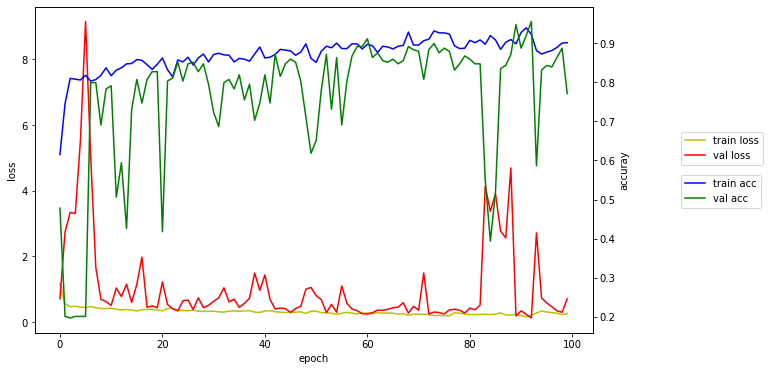

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(10,6))
acc_ax = loss_ax.twinx()

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

acc_ax.legend(loc='upper left', bbox_to_anchor=(1.15, 0.5))
loss_ax.legend(loc='lower left', bbox_to_anchor=(1.15, 0.5))

plt.show()